## Multi-label image classification using ResNet-34 - ECE 5524 Advanced Machine Learning Final Course Project

Team members - Sanjana Bharadwaj, Gauri Sharma, Rohit Sathye

Mounting on drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Importing all the necessary libraries

In [ ]:
%matplotlib inline
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from numpy import ones
from numpy import asarray
from numpy import mean
from numpy import std
from numpy import dstack
import math as mt
import time
import os
from os import listdir
import sys
import cv2
import matplotlib.pyplot as pyplot 
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from matplotlib.image import imread
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from progressbar import ProgressBar
For optimifrom sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score       # test f-beta score
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras import backend
from keras.utils import to_categorical
from keras.optimizers import SGD
import tensorflow as tf
from numpy import load
from sklearn.model_selection import RepeatedKFold
from keras import backend
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import tensorflow as tf
from google.colab.patches import cv2_imshow

Visualizing the dataset

In [ ]:
# plot the first 9 images in the planet dataset
# define location of dataset

folder = '/content/drive/MyDrive/AML/AMLProject/train-jpg'
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # define filename
 filename = folder + '/train_' + str(i) + '.jpg'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 pyplot.imshow(image)
# show the figure
pyplot.show()

Create Mappings


In [ ]:
# load and summarize the mapping file for the planet dataset
# load file as CSV
filename = 'train_v2.csv'
mapping_csv = read_csv(filename)
# summarize properties
print(mapping_csv.shape)
print(mapping_csv[:10])

In [ ]:
# create a set of labels
labels = set()
for i in range(len(mapping_csv)):
 # convert spaced separated tags into an array of tags
 tags = mapping_csv['tags'][i].split(' ')
 # add tags to the set of known labels
 labels.update(tags)

In [ ]:
# convert set of labels to a list to list
labels = list(labels)
# order set alphabetically
labels.sort()
print(labels)

In [ ]:
# dict that maps labels to integers, and the reverse
labels_map = {labels[i]:i for i in range(len(labels))}
inv_labels_map = {i:labels[i] for i in range(len(labels))}
print(inv_labels_map)
print(labels_map)

Create an In-Memory DataSet

In [ ]:
# load and prepare planet dataset and save to file
# create a mapping of tags to integers given the loaded mapping file
pbar = ProgressBar()
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

# create a mapping of filename to a list of tags
def create_file_mapping(mapping_csv):
	mapping = dict()
	for i in range(len(mapping_csv)):
		name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
		mapping[name] = tags.split(' ')
	return mapping

# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
	# create empty vector
	encoding = zeros(len(mapping), dtype='uint8')
	# mark 1 for each tag in the vector
	for tag in tags:
		encoding[mapping[tag]] = 1
	return encoding

# load all images into memory
def load_dataset(path, file_mapping, tag_mapping):
	photos, targets = list(), list()
	# enumerate files in the directory
	for filename in pbar(listdir(folder)):
		# load image
		photo = load_img(path + filename, target_size=(128,128))
		# convert to numpy array
		photo = img_to_array(photo, dtype='uint8')
		# get tags
		tags = file_mapping[filename[:-4]]
		# one hot encode tags
		target = one_hot_encode(tags, tag_mapping)
		# store
		photos.append(photo)
		targets.append(target)
	X = asarray(photos, dtype='uint8')
	y = asarray(targets, dtype='uint8')
	return X, y

# load the mapping file
filename = 'train_v2.csv'
mapping_csv = read_csv(filename)
# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(mapping_csv)
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)
# load the jpeg images
folder = 'train-jpg/'
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)
# save both arrays to one file in compressed format
savez_compressed('planet_data.npz', X, y)

  1% (407 of 40373) |              | Elapsed Time: 0:02:31 ETA:  1 day, 6:05:56

Planet_data.npz file containing all the mappings is saved on drive and downloaded for direct use 

In [ ]:
!gdown https://drive.google.com/uc?id=1y5tQLr3UrwGAr9zlhxCnnZkiEP4xmjKR

Downloading...
From: https://drive.google.com/uc?id=1y5tQLr3UrwGAr9zlhxCnnZkiEP4xmjKR
To: /content/planet_data.npz
100% 1.28G/1.28G [00:05<00:00, 240MB/s]


Confirm if the Data is Loaded correctly into the Memory

In [ ]:
# load prepared planet dataset
from numpy import load
data = load('planet_data.npz')
X, y = data['arr_0'], data['arr_1']
print('Loaded: ', X.shape, y.shape)

Loaded:  (40373, 128, 128, 3) (40373, 17)


Loading dataset with 70:30 train/test split

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY


Calculating F-beta score

In [ ]:
# test f-beta score
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
 # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

Model architecture

1. Baseline model

In [ ]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=in_shape))	
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

2. ResNet-34 

In [ ]:
# Modified Resnet model
def identity_block(x, filter,use_dropout=True):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    if use_dropout:
      x = Dropout(0.3)(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter,use_dropout=True):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    if use_dropout:
      x = Dropout(0.3)(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape=(128, 128, 3), classes=17, use_dropout=True):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size, use_dropout=True)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size,use_dropout=True)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size,use_dropout=True)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if use_dropout:
      x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(classes, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    # Compile model
    opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    # model_plot(model);
    return model

Loading train and test dataset

In [ ]:
trainX, trainY, testX, testY = load_dataset()

(28261, 128, 128, 3) (28261, 17) (12112, 128, 128, 3) (12112, 17)


Pipeline for training ResNet and Baseline with Data Augmentation

In [ ]:
import numpy
import tensorflow as tf
from numpy import load

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0),
  Random(mode="horizontal_and_vertical", seed=None),
  tf.keras.layers.RandomRotation(
    factor = 0.3,
    fill_mode='reflect',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,
),
tf.keras.layers.RandomTranslation(
    height_factor = 0.3,
    width_factor=0.2,
    fill_mode='reflect',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,
),


])

# Define the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(32)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Define the testing dataset
test_ds = tf.data.Dataset.from_tensor_slices((testX, testY))
test_ds = test_ds.batch(32)
test_ds = test_ds.map(lambda x, y: (data_augmentation(x), y))

# Define the model
# model = define_model()
model = ResNet34()

# Train the model
history = model.fit(train_ds, epochs=50, validation_data=test_ds)



Epoch 1/50
884/884 [==============================] - 225s 231ms/step - loss: 0.3193 - fbeta: 0.6729 - val_loss: 0.2194 - val_fbeta: 0.7048
Epoch 2/50
884/884 [==============================] - 231s 261ms/step - loss: 0.2044 - fbeta: 0.7340 - val_loss: 0.2645 - val_fbeta: 0.7242
Epoch 3/50
884/884 [==============================] - 208s 235ms/step - loss: 0.1831 - fbeta: 0.7589 - val_loss: 0.2545 - val_fbeta: 0.7370
Epoch 4/50
884/884 [==============================] - 202s 228ms/step - loss: 0.1709 - fbeta: 0.7728 - val_loss: 0.2143 - val_fbeta: 0.7699
Epoch 5/50
884/884 [==============================] - 200s 226ms/step - loss: 0.1645 - fbeta: 0.7836 - val_loss: 0.4014 - val_fbeta: 0.7384
Epoch 6/50
884/884 [==============================] - 230s 260ms/step - loss: 0.1602 - fbeta: 0.7890 - val_loss: 0.2097 - val_fbeta: 0.7498
Epoch 7/50
884/884 [==============================] - 230s 260ms/step - loss: 0.1561 - fbeta: 0.7952 - val_loss: 0.1893 - val_fbeta: 0.7633
Epoch 8/50
884/884 [

Visualizing results

dict_keys(['loss', 'fbeta', 'val_loss', 'val_fbeta'])


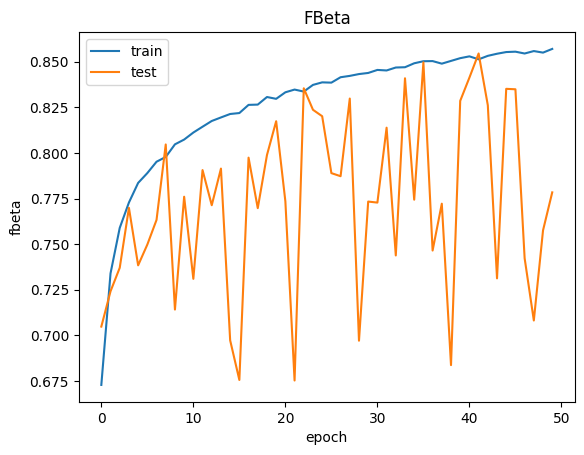

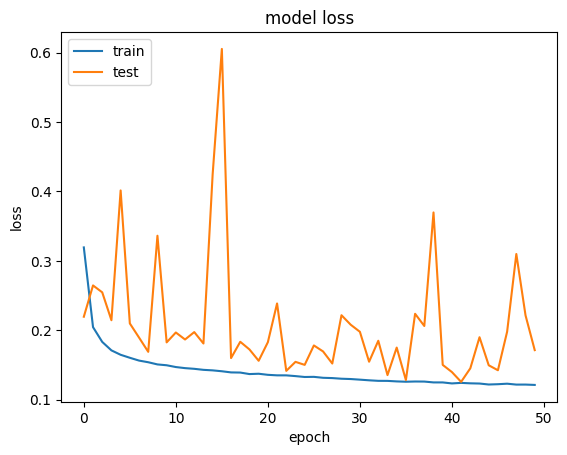

In [ ]:

# graph for resnet with dropout with data augmentation
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['fbeta'])
plt.plot(history.history['val_fbeta'])
plt.title('FBeta')
plt.ylabel('fbeta')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# make a prediction on the test set
y_pred= model.predict(testX)
# round the probabilities to class labels
y_pred= round(y_pred);

predict_fBeta = fbeta(testY, y_pred, beta=2)
print('Final F-Beta is -', numpy.mean(predict_fBeta))

Pipeline for training ResNet and Baseline model without data augmentation

In [ ]:
import tensorflow as tf
from numpy import load

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0),
])

# Define the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(32)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Define the testing dataset
test_ds = tf.data.Dataset.from_tensor_slices((testX, testY))
test_ds = test_ds.batch(32)
test_ds = test_ds.map(lambda x, y: (data_augmentation(x), y))

# Define the model
#model = define_model()
model = define_model_with_resnet()

# Train the model
history = model.fit(train_ds, epochs=50, validation_data=test_ds)


Epoch 1/50
884/884 [==============================] - 72s 74ms/step - loss: 0.2074 - fbeta: 0.7448 - val_loss: 0.1745 - val_fbeta: 0.7726
Epoch 2/50
884/884 [==============================] - 64s 72ms/step - loss: 0.1580 - fbeta: 0.7900 - val_loss: 0.1898 - val_fbeta: 0.7648
Epoch 3/50
884/884 [==============================] - 66s 74ms/step - loss: 0.1442 - fbeta: 0.8111 - val_loss: 0.1736 - val_fbeta: 0.7309
Epoch 4/50
884/884 [==============================] - 63s 71ms/step - loss: 0.1350 - fbeta: 0.8235 - val_loss: 0.1432 - val_fbeta: 0.8031
Epoch 5/50
884/884 [==============================] - 63s 71ms/step - loss: 0.1289 - fbeta: 0.8325 - val_loss: 0.1628 - val_fbeta: 0.7640
Epoch 6/50
884/884 [==============================] - 66s 74ms/step - loss: 0.1222 - fbeta: 0.8423 - val_loss: 0.2005 - val_fbeta: 0.7229
Epoch 7/50
884/884 [==============================] - 63s 71ms/step - loss: 0.1168 - fbeta: 0.8512 - val_loss: 0.1415 - val_fbeta: 0.8122
Epoch 8/50
884/884 [==============

Visualizing the results

dict_keys(['loss', 'fbeta', 'val_loss', 'val_fbeta'])


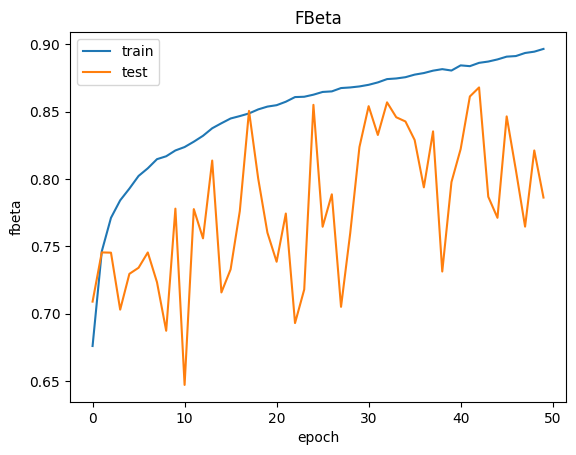

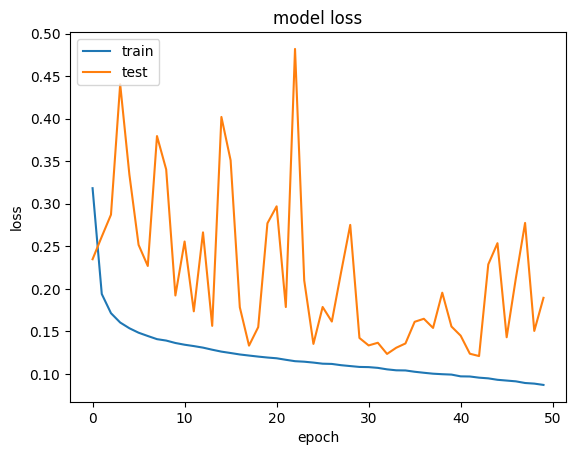

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['fbeta'])
plt.plot(history.history['val_fbeta'])
plt.title('FBeta')
plt.ylabel('fbeta')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'fbeta', 'val_loss', 'val_fbeta'])


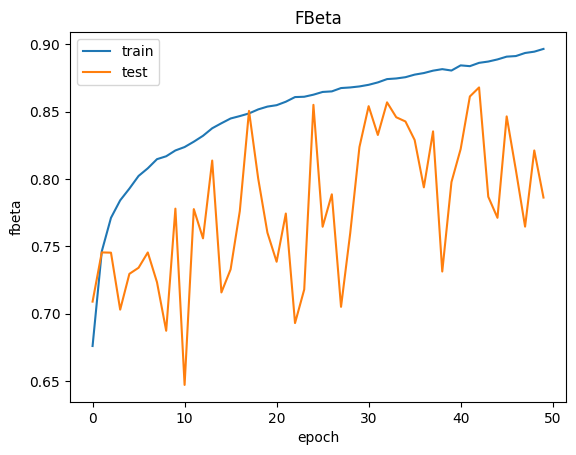

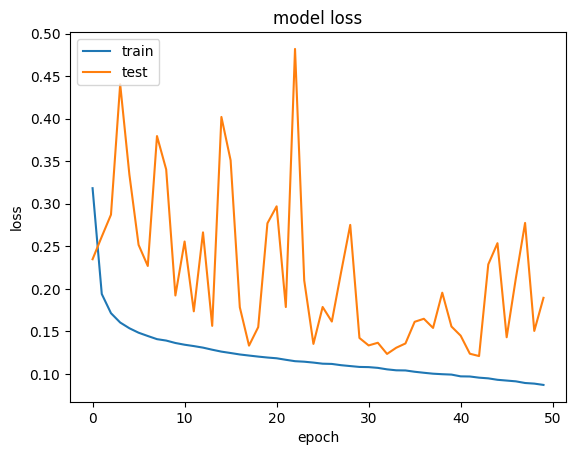

In [ ]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['fbeta'])
plt.plot((history.history['val_fbeta']))
plt.title('FBeta')
plt.ylabel('fbeta')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()